In [8]:
from langchain_community.utils.math import cosine_similarity
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr, spearmanr

import voyageai
import os

from dotenv import load_dotenv


In [9]:
# Load environment variables from the .env file
load_dotenv()

# Access environment variables
VO_API_KEY = os.getenv('VO_API_KEY')

In [2]:
# Load the STS-B dataset
dataset = load_dataset("stsb_multi_mt", name="en")


Generating dev split: 100%|██████████| 1500/1500 [00:00<00:00, 879800.87 examples/s]


In [23]:
vo = voyageai.Client(api_key=VO_API_KEY)

In [24]:
dataset_train = dataset["train"]

In [25]:
print(dataset_train[:4])
dataset_train["sentence1"][0]

{'sentence1': ['A plane is taking off.', 'A man is playing a large flute.', 'A man is spreading shreded cheese on a pizza.', 'Three men are playing chess.'], 'sentence2': ['An air plane is taking off.', 'A man is playing a flute.', 'A man is spreading shredded cheese on an uncooked pizza.', 'Two men are playing chess.'], 'similarity_score': [5.0, 3.799999952316284, 3.799999952316284, 2.5999999046325684]}


'A plane is taking off.'

In [45]:
sentance1 = dataset_train["sentence1"][0]
sentance2 = dataset_train["sentence2"][0]
gold_score = dataset_train["similarity_score"][0]

In [46]:
sentance1_vector = vo.embed(sentance1, model="voyage-3", input_type="document")
sentance2_vector = vo.embed(sentance2, model="voyage-3", input_type="document")


In [47]:
sentance1_vector.embeddings[0]

[0.0214348454028368,
 -0.052155040204524994,
 -0.028746014460921288,
 -0.003486067056655884,
 0.05777173489332199,
 0.004512004088610411,
 0.012800727970898151,
 0.014974089339375496,
 0.008102960884571075,
 0.045509934425354004,
 -0.04562576860189438,
 0.0011739121982827783,
 -0.04917999729514122,
 -0.03195696696639061,
 0.03346144035458565,
 -0.01668057218194008,
 0.022997941821813583,
 0.029915688559412956,
 0.03141733631491661,
 0.01567441038787365,
 -0.04086796194314957,
 0.028690921142697334,
 -0.03170834109187126,
 0.012955413199961185,
 -0.01059770118445158,
 0.028090545907616615,
 -0.015804728493094444,
 0.05950081720948219,
 -0.01539364643394947,
 0.020116135478019714,
 -0.0055746701546013355,
 -0.054237283766269684,
 -0.005703927483409643,
 -0.00334374257363379,
 0.021593768149614334,
 0.04722771421074867,
 0.03575699403882027,
 -0.0195835679769516,
 -0.0020716513972729445,
 -0.06026364862918854,
 0.05537588149309158,
 0.013578391633927822,
 -0.006300419103354216,
 -0.005064

### Cosine Similarity: Definition

**Cosine similarity** measures the cosine of the angle between two non-zero vectors in a multi-dimensional space. It is commonly used to determine how similar two vectors are in terms of their orientation, irrespective of their magnitude. The result is a single scalar value between $-1$ and $1$:

- $ +1 $: Vectors point in the same direction (maximal similarity).
- $ 0 $: Vectors are orthogonal (no similarity).
- $ -1 $: Vectors point in opposite directions (maximal dissimilarity).

In the context of text or data science, cosine similarity is frequently used to compare the similarity between two documents or data points.

---

### Equation for Cosine Similarity

For two vectors $ \mathbf{A} = [A_1, A_2, \dots, A_n] $ and $ \mathbf{B} = [B_1, B_2, \dots, B_n] $, the cosine similarity is defined as:

$$
\text{Cosine Similarity} = \cos(\theta) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}
$$

Where:
- $ \mathbf{A} \cdot \mathbf{B} = \sum_{i=1}^n A_i B_i $: Dot product of $ \mathbf{A} $ and $ \mathbf{B} $.
- $ \|\mathbf{A}\| = \sqrt{\sum_{i=1}^n A_i^2} $: Magnitude (or norm) of vector $ \mathbf{A} $.
- $ \|\mathbf{B}\| = \sqrt{\sum_{i=1}^n B_i^2} $: Magnitude (or norm) of vector $ \mathbf{B} $.
- $ \theta $: Angle between $ \mathbf{A} $ and $ \mathbf{B} $.

---

### Properties of Cosine Similarity
1. **Scale Invariance:**
   - Since it normalizes the vectors to unit length, cosine similarity is independent of the vector magnitudes.
   - Useful for comparing documents of varying lengths or feature vectors with different scales.

2. **Range:**
   - $ -1 $ to $ +1 $:
     - $ +1 $: Identical orientation.
     - $ 0 $: Completely dissimilar (orthogonal).
     - $ -1 $: Opposite orientation (applies in signed spaces, rarely in text similarity).

3. **Applicability:**
   - Works well for sparse or high-dimensional data (e.g., text data represented as TF-IDF vectors).

---

### Example: Cosine Similarity for Texts
In text analysis, cosine similarity is used to compare two documents' term frequency vectors:
- $ \mathbf{A} $: Term frequency vector for document 1.
- $ \mathbf{B} $: Term frequency vector for document 2.

If the two documents share similar terms in similar proportions, their cosine similarity will be close to $ +1 $.

---

Would you like an example implementation in Python or an explanation of its applications in specific fields?

In [48]:
similarity = 1 - cosine(sentance1_vector.embeddings[0], sentance2_vector.embeddings[0])

In [49]:
similarity, gold_score

(0.9775872895279095, 5.0)

In [63]:
gold_scores = []
cosine_similarities = []

counter = 0
N = 500

for example in dataset_train:
    sentance1, sentance2, gold_score = example["sentence1"], example["sentence2"], example["similarity_score"]
    print(sentance1, sentance2, gold_score)
    
    # Increment the counter
    counter += 1
    
    if counter >= N:
        break
    
    sentance1_vector = vo.embed(sentance1, model="voyage-3", input_type="document")
    sentance2_vector = vo.embed(sentance2, model="voyage-3", input_type="document")
    similarity = 1 - cosine(sentance1_vector.embeddings[0], sentance2_vector.embeddings[0])
    gold_scores.append(gold_score)
    cosine_similarities.append(similarity)
    

A plane is taking off. An air plane is taking off. 5.0
A man is playing a large flute. A man is playing a flute. 3.799999952316284
A man is spreading shreded cheese on a pizza. A man is spreading shredded cheese on an uncooked pizza. 3.799999952316284
Three men are playing chess. Two men are playing chess. 2.5999999046325684
A man is playing the cello. A man seated is playing the cello. 4.25
Some men are fighting. Two men are fighting. 4.25
A man is smoking. A man is skating. 0.5
The man is playing the piano. The man is playing the guitar. 1.600000023841858
A man is playing on a guitar and singing. A woman is playing an acoustic guitar and singing. 2.200000047683716
A person is throwing a cat on to the ceiling. A person throws a cat on the ceiling. 5.0
The man hit the other man with a stick. The man spanked the other man with a stick. 4.199999809265137
A woman picks up and holds a baby kangaroo. A woman picks up and holds a baby kangaroo in her arms. 4.599999904632568
A man is playing 

In [64]:
# Calculate correlations
pearson_corr, _ = pearsonr(gold_scores, cosine_similarities)
spearman_corr, _ = spearmanr(gold_scores, cosine_similarities)

print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}")

Pearson Correlation: 0.8907
Spearman Correlation: 0.8938


In [73]:
sentance1_vector = vo.embed(sentance1, model="voyage-3-large", input_type="document", output_dimension=256)

In [74]:
len(sentance1_vector.embeddings[0])

256

Dimension 256: Pearson = 0.9067, Spearman = 0.8922
Dimension 512: Pearson = 0.9157, Spearman = 0.8919
Dimension 1024: Pearson = 0.9181, Spearman = 0.8937
Dimension 2048: Pearson = 0.9197, Spearman = 0.8946


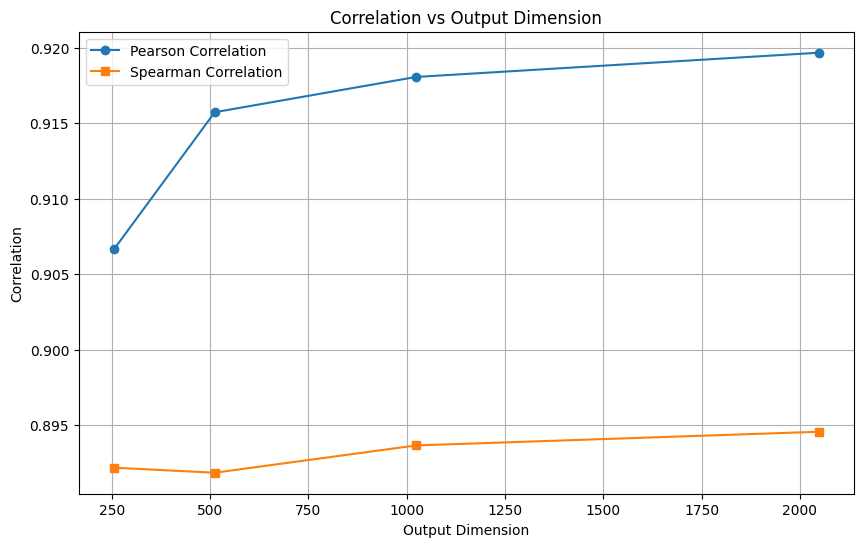

In [80]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr, spearmanr


def analyze_similarity_correlations(dataset_train, model_name, input_type, dimensions, N=250):
    """
    Analyzes the relationship between vector embedding dimensions and correlation metrics.

    Parameters:
        dataset_train (list): List of dictionaries with keys "sentence1", "sentence2", and "similarity_score".
        model_name (str): Name of the embedding model.
        input_type (str): Type of input for the embedding model.
        dimensions (list): List of output dimensions to evaluate.
        N (int): Number of examples to analyze.

    Returns:
        None
    """
    pearson_corrs = []
    spearman_corrs = []

    for dim in dimensions:
        gold_scores = []
        cosine_similarities = []

        for idx, example in enumerate(dataset_train):
            if idx >= N:
                break

            sentence1, sentence2, gold_score = (
                example["sentence1"],
                example["sentence2"],
                example["similarity_score"],
            )

            sentence1_vector = vo.embed(sentence1, model=model_name, input_type=input_type, output_dimension=dim)
            sentence2_vector = vo.embed(sentence2, model=model_name, input_type=input_type, output_dimension=dim)

            similarity = 1 - cosine(sentence1_vector.embeddings[0], sentence2_vector.embeddings[0])

            gold_scores.append(gold_score)
            cosine_similarities.append(similarity)

        pearson_corr, _ = pearsonr(gold_scores, cosine_similarities)
        spearman_corr, _ = spearmanr(gold_scores, cosine_similarities)
        

        pearson_corrs.append(pearson_corr)
        spearman_corrs.append(spearman_corr)

        print(f"Dimension {dim}: Pearson = {pearson_corr:.4f}, Spearman = {spearman_corr:.4f}")

    # Plot the correlations vs dimensions
    plt.figure(figsize=(10, 6))
    plt.plot(dimensions, pearson_corrs, marker="o", label="Pearson Correlation")
    plt.plot(dimensions, spearman_corrs, marker="s", label="Spearman Correlation")
    plt.xlabel("Output Dimension")
    plt.ylabel("Correlation")
    plt.title("Correlation vs Output Dimension")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
dimensions_to_test = [256, 512, 1024, 2048]
analyze_similarity_correlations(dataset_train, "voyage-3-large", "document", dimensions_to_test, N=250)
